## Build Regression Model with TF DenseFeatures

[Reference](https://www.tensorflow.org/tutorials/keras/regression)


### Read Data

In [405]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [406]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
raw_dataset.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'ModelYear', 'Origin']
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [407]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
ModelYear       0
Origin          0
dtype: int64

In [408]:
dataset = dataset.dropna()

In [409]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [410]:
# Split data 80:20
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [411]:
train_dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear', 'Origin'],
      dtype='object')

In [412]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear,Origin
146,28.0,4,90.0,75.0,2125.0,14.5,74,USA
282,22.3,4,140.0,88.0,2890.0,17.3,79,USA
69,12.0,8,350.0,160.0,4456.0,13.5,72,USA
378,38.0,4,105.0,63.0,2125.0,14.7,82,USA
331,33.8,4,97.0,67.0,2145.0,18.0,80,Japan


In [413]:
train_labels = train_dataset['MPG']

In [414]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
ModelYear,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [415]:
categorical_feature_list = ['Origin']
# Treat Model Year and Cylinders as numerical
numerical_feature_list = ['Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'ModelYear']

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset[numerical_feature_list])
normed_test_data = norm(test_dataset[numerical_feature_list])

norm_train_data = pd.concat([ train_dataset[categorical_feature_list + ['MPG']],  normed_train_data], 
                            axis=1, sort=False)
norm_test_data = pd.concat([ test_dataset[categorical_feature_list + ['MPG']], normed_test_data], axis=1, sort=False)

norm_train_data.to_csv("mpg_train_data.csv", index=False)
norm_test_data.to_csv("mpg_test_data.csv", index=False)

norm_train_data.head()

,Origin,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,ModelYear
146,USA,28.0,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397
282,USA,22.3,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910
69,USA,12.0,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519
378,USA,38.0,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094
331,Japan,33.8,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971


- Use TF Dataset API and Feature Column APIs 

In [416]:
train_data = pd.read_csv("mpg_train_data.csv" )
test_data = pd.read_csv("mpg_test_data.csv" )

#adapted from https://www.tensorflow.org/tutorials/structured_data/feature_columns
def df_to_dataset(df, predictor,  batch_size=32):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

PREDICTOR_FIELD = 'MPG'
batch_size = 128
train_ds = df_to_dataset(train_data, PREDICTOR_FIELD, batch_size=batch_size)
test_ds = df_to_dataset(test_data, PREDICTOR_FIELD, batch_size=batch_size)

sample_batch = next(iter(train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

### Convert Categorical Feature to One Hot Encoded Feature

In [417]:
# only feature 
v_list = tf.feature_column.categorical_column_with_vocabulary_list("Origin", 
                                                            train_data['Origin'].unique())
one_hot_origin_feature = tf.feature_column.indicator_column(v_list)

print("Example categorical field:\n{}".format(one_hot_origin_feature))
demo(one_hot_origin_feature, sample_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0))

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 

### convert numerical features
Dataset has already been normalized

In [418]:
def create_tf_numerical_feature_cols(numerical_col_list):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        tf_numeric_feature = tf.feature_column.numeric_column(
                    key=c,  dtype=tf.float64)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

tf_numerical_feature_list = create_tf_numerical_feature_cols(numerical_feature_list)

tf_numerical_feature_list

[NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [419]:
# take first numerical feature
test_cont_var1 = tf_numerical_feature_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, sample_batch)

Example continuous field:
NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



tf.Tensor(
[[ 1.4838872 ]
 [-0.86934805]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [-0.86934805]
 [ 0.30726957]
 [ 0.30726957]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [-0.86934805]
 [-1.4576569 ]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [ 0.30726957]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.86934805]
 [ 0.30726957]
 [ 1.4838872 ]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 0.30726957]
 [ 0.30726957]
 [ 0.30726957]
 [-0.86934805]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [ 1.4838872 ]
 [ 0.30726957]
 [ 0.30726957]
 [ 0.30726957]
 [ 0.30726957]
 [ 1.4838872 ]
 [ 0.30726957]
 [-0.86934805]
 [-0.86934805]
 [ 1.4838872 ]
 [ 0.30726957]

### Combine TF Features with DenseFeatures

In [420]:
feature_columns = [ one_hot_origin_feature ] + tf_numerical_feature_list
feature_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Origin', vocabulary_list=('USA', 'Japan', 'Europe'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 NumericColumn(key='Cylinders', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Displacement', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Horsepower', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Weight', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='Acceleration', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None),
 NumericColumn(key='ModelYear', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=None)]

In [421]:
dense_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [422]:
# TF architecture 
def build_model(dense_feature_layer):
    model = tf.keras.Sequential([
    dense_feature_layer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    

    return model

model = build_model(dense_feature_layer)

In [423]:
# No validation set b/c need to build separate TF dataset
EPOCHS = 2000
# Set to patience to 100 so it trains to end of epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
history = model.fit(train_ds,   callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Train for 3 steps
Epoch 1/2000
3/3 [==============================] - 1s 185ms/step - loss: 599.5049 - mae: 23.4217 - mse: 605.2550
Epoch 2/2000
3/3 [==============================] - 0s 8ms/step - loss: 585.2582 - mae: 22.8632 - mse: 580.2108
Epoch 3/2000
3/3 [==============================] - 0s 8ms/step - loss: 563.3175 - mae: 22.4445 - mse: 561.8296
Epoch 4/2000
3/3 [==============================] - 0s 8ms/step - loss: 537.0141 - mae: 22.0405 - mse: 544.6807
Epoch 5/2000
3/3 [==============================] - 0s 8ms/step - loss: 525.9078 - mae: 21.6261 - mse: 527.3805
Epoch 6/2000
3/3 [==============================] - 0s 8ms/step - loss: 499.5401 - mae: 21.1844 - mse: 509.2787
Epoch 7/2000
3/3 [==============================] - 0s 8ms/step - loss: 488.1403 - mae: 20.7318 - mse: 490.9822
Epoch 8/2000
3/3 [==============================] - 0s 8ms/step - loss: 471.7823 - mae: 20.2512 - mse: 471.7396
Epoch 9/2000
3/3 [==============================] - 0s 9ms/step - loss: 436.2029 - m

In [424]:
loss, mae, mse = model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 5.4581 - mae: 1.8338 - mse: 5.4581


In [425]:
test_labels = test_data[PREDICTOR_FIELD].values

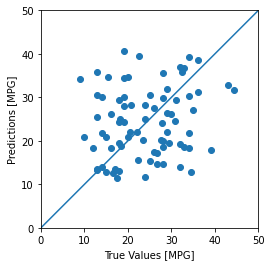

In [426]:
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


### Prediction 

In [427]:
model_pred_outputs = {
    "pred": test_predictions,
    "actual_value": test_labels,
}
model_output_df = pd.DataFrame(model_pred_outputs)

model_output_df.head()

,pred,actual_value
0,20.865280,15.0
1,20.946115,10.0
2,34.185570,9.0
3,30.460430,25.0
4,24.399460,19.0


## Model Evaluation 

- Create binary label for mileage prediction over 25 miles per gallon
    - 0 = Not Fuel Efficient, < 25 MPG
    - 1 = Fuel Efficient >= 25 MPG

In [428]:
# Convert Regression Output to binary classification output
model_output_df.head()

,pred,actual_value
0,20.865280,15.0
1,20.946115,10.0
2,34.185570,9.0
3,30.460430,25.0
4,24.399460,19.0


In [429]:
def convert_to_binary(df, pred_field, actual_field):
    df['score'] = df[pred_field].apply(lambda x: 1 if x>=25 else 0 )
    df['label_value'] = df[actual_field].apply(lambda x: 1 if x>=25 else 0)
    return df

binary_df = convert_to_binary(model_output_df, 'pred', 'actual_value')
binary_df.head()

,pred,actual_value,score,label_value
0,20.865280,15.0,0,0
1,20.946115,10.0,0,0
2,34.185570,9.0,1,0
3,30.460430,25.0,1,1
4,24.399460,19.0,0,0


### Common Model Evaluation Metrics

In [430]:
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

In [431]:
print(classification_report(binary_df['label_value'], binary_df['score']))

              precision    recall  f1-score   support

           0       0.55      0.56      0.55        41
           1       0.50      0.49      0.49        37

    accuracy                           0.53        78
   macro avg       0.52      0.52      0.52        78
weighted avg       0.53      0.53      0.53        78



In [432]:
#F1
f1_score(binary_df['label_value'], binary_df['score'], average='weighted')

0.5252495757529593

In [433]:
#AUC - area under the ROC curve
roc_auc_score(binary_df['label_value'], binary_df['score'])

0.523731048121292

### Brier Score

In [434]:
random_predictions = np.random.random((100))
random_predictions

array([0.54551097, 0.49277175, 0.73295227, 0.01608002, 0.88228058,
       0.66008903, 0.25162105, 0.35989346, 0.32535464, 0.25928043,
       0.99875794, 0.96629024, 0.81568965, 0.56669219, 0.0153817 ,
       0.223669  , 0.59381192, 0.99492214, 0.93094014, 0.5281491 ,
       0.27889769, 0.81776479, 0.87483917, 0.78016733, 0.13489747,
       0.31961316, 0.03780645, 0.26444005, 0.84061417, 0.1130446 ,
       0.81896219, 0.2000294 , 0.12168862, 0.4243887 , 0.97000241,
       0.06488557, 0.6317076 , 0.10280891, 0.77092507, 0.92425319,
       0.04443566, 0.0736391 , 0.69372838, 0.64298037, 0.58117408,
       0.90214443, 0.32095918, 0.98515894, 0.07721711, 0.82475868,
       0.53445279, 0.16572798, 0.1130714 , 0.35924856, 0.78749478,
       0.56514349, 0.69392122, 0.91616227, 0.50019674, 0.07933991,
       0.53141368, 0.32619755, 0.69443413, 0.34907722, 0.92744308,
       0.37202953, 0.65690185, 0.73229485, 0.01138015, 0.99576939,
       0.37656499, 0.46170288, 0.77854511, 0.50302427, 0.97584

In [435]:
random_labels = np.random.choice([0, 1], 100)
random_labels

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0])

- Convert probability to binary predictions

In [436]:
probability_prediction_df = pd.DataFrame({"prob_prediction": random_predictions,
                "binary_prediction": np.array([ 1 if abs(x)>=0.5 else 0 for x in random_predictions], dtype=int),
                                "label": random_labels})

In [437]:
probability_prediction_df.head()

,prob_prediction,binary_prediction,label
0,0.545511,1,1
1,0.492772,0,1
2,0.732952,1,0
3,0.016080,0,0
4,0.882281,1,0


In [438]:
y_true = probability_prediction_df['label'].values 
y_pred = probability_prediction_df['binary_prediction'].values

In [439]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.45


In [440]:
bs_loss = brier_score_loss(y_true, probability_prediction_df['prob_prediction'])
print(bs_loss)

0.38703477818360066


### Misclassified

In [441]:
missclassified_df = probability_prediction_df[probability_prediction_df['binary_prediction']!=probability_prediction_df['label']]

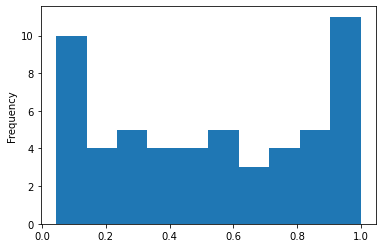

In [442]:
missclassified_df['prob_prediction'].plot(kind='hist')

##  Group Bias Analysis

### Select groups to analyze
- Selected 'origin' field which gives the country of origin for the car.
combine binary df with original test df, order was not shuffled so can do

In [443]:
merged_binary_df = binary_df.assign(origin = test_data['Origin'].values)

merged_binary_df.head()

,pred,actual_value,score,label_value,origin
0,20.865280,15.0,0,0,USA
1,20.946115,10.0,0,0,USA
2,34.185570,9.0,1,0,USA
3,30.460430,25.0,1,1,Japan
4,24.399460,19.0,0,0,USA


### Prepare Data

In [444]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

In [445]:
ae_df, _ = preprocess_input_df(merged_binary_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [36]}


The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


### Analyze Groups

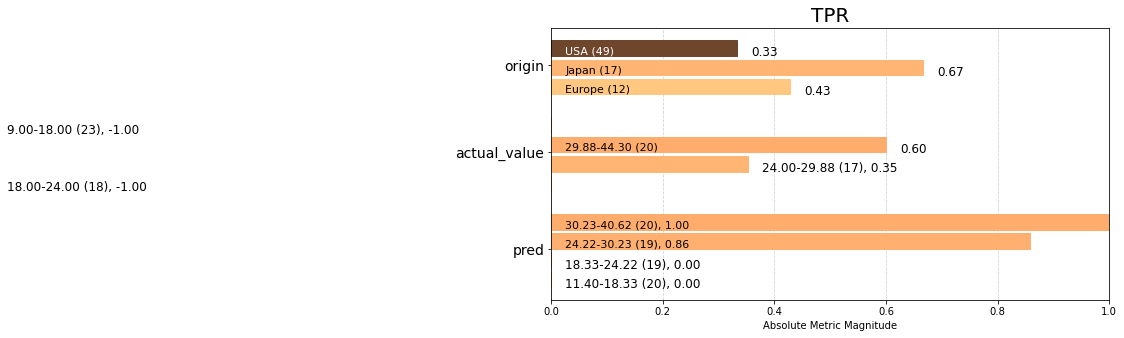

In [446]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.05)

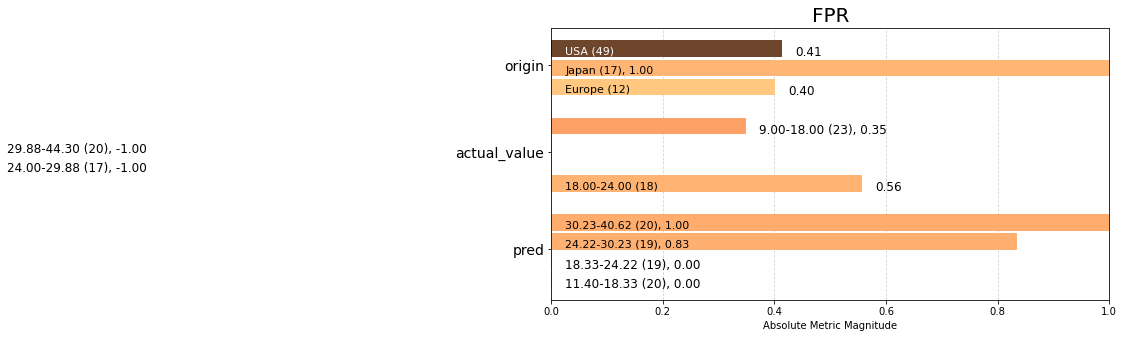

In [447]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.05)

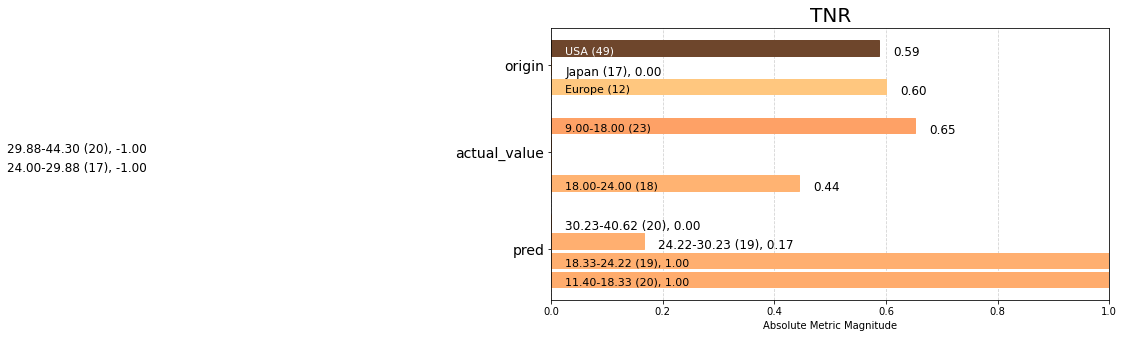

In [448]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.05)

## Train Uncertainty Estimation Model with TF Probability

In [449]:
import tensorflow_probability as tfp

### Aleatoric Uncertainty
- Known Unknowns
- 2 Main Changes to our network 
    - Add a second unit to the last dense layer before passing it to Tensorflow Probability layer to model for the predictor y and the heteroscedasticity or unequal scattering of data
    - DistributionLambda distribution mean and std
- DistributionLambda is a special Keras layer that uses a Python lambda to construct a distribution based on the layer inputs and the output of the final layer of the model is passed into the loss function. Lastly. this model will return a distribution for both mean and standard deviation.

In [450]:
train_label_stats = train_labels.describe()
train_label_stats

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [451]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(  
            lambda t:tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])

            )
         )
  
        
        
    ])
    return model

def build_prob_model(train_ds,   feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(tf.optimizers.Adam(learning_rate=0.05), loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds, 
                        epochs=epochs)
    return model, history

### Train Probability Model

In [452]:
prob_model, history = build_prob_model(train_ds, dense_feature_layer,  epochs=500)

Train for 3 steps
Epoch 1/500
3/3 [==============================] - 1s 172ms/step - loss: 241.9842 - mse: 382.5674
Epoch 2/500
3/3 [==============================] - 0s 9ms/step - loss: 16.4700 - mse: 4220.5786
Epoch 3/500
3/3 [==============================] - 0s 8ms/step - loss: 11.4785 - mse: 14169.7930
Epoch 4/500
3/3 [==============================] - 0s 8ms/step - loss: 7.3080 - mse: 17235.1367
Epoch 5/500
3/3 [==============================] - 0s 8ms/step - loss: 5.6681 - mse: 14944.0410
Epoch 6/500
3/3 [==============================] - 0s 8ms/step - loss: 5.2399 - mse: 9928.8936
Epoch 7/500
3/3 [==============================] - 0s 8ms/step - loss: 5.3506 - mse: 8923.8086
Epoch 8/500
3/3 [==============================] - 0s 8ms/step - loss: 5.6000 - mse: 13629.2930
Epoch 9/500
3/3 [==============================] - 0s 8ms/step - loss: 5.7994 - mse: 16647.3496
Epoch 10/500
3/3 [==============================] - 0s 9ms/step - loss: 5.8891 - mse: 21259.4238
Epoch 11/500
3/3 [==

### Extract Mean and Standard Deviation Output

In [453]:
feature_column_list = categorical_feature_list + numerical_feature_list
x_tst = dict(test_data[feature_column_list])
yhat = prob_model(x_tst)
prob_preds = prob_model.predict(test_ds)
m = yhat.mean()
s = yhat.stddev()

In [454]:
m[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[14.711223],
       [10.835672],
       [11.409917],
       [25.923098],
       [19.35082 ],
       [13.80182 ],
       [13.604611],
       [13.2991  ],
       [19.668123],
       [34.059475]], dtype=float32)>

In [455]:
s[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.86369735],
       [0.7758067 ],
       [0.75688523],
       [1.369047  ],
       [1.1367917 ],
       [0.8876235 ],
       [0.8771673 ],
       [0.8531578 ],
       [1.0656117 ],
       [2.31183   ]], dtype=float32)>

In [456]:
prob_outputs = {
    "pred": prob_preds.flatten(),
    "actual_value": test_data['MPG'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [457]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,23.149851,15.0,14.711223,0.863697
1,11.650378,10.0,10.835672,0.775807
2,16.556526,9.0,11.409917,0.756885
3,15.659798,25.0,25.923098,1.369047
4,15.842098,19.0,19.350821,1.136792


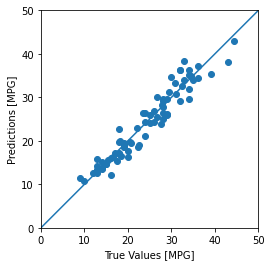

In [458]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, m.numpy().flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


## Model Interpretability with Shapley Values

- [Shap](https://github.com/slundberg/shap) 

In [459]:
# adapted from https://github.com/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb
# https://towardsdatascience.com/understand-how-your-tensorflow-model-is-making-predictions-d0b3c7e88500

In [460]:
import shap
shap.initjs()

### Train Model without Dense Features

In [461]:
def build_shap_model( num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[num_features]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [462]:
shap_num_features = len( numerical_feature_list)
shap_feature_columns =  tf_numerical_feature_list
#shap_feature_layer = tf.keras.layers.DenseFeatures(shap_feature_columns)
shap_model = build_shap_model( shap_num_features)

In [463]:
EPOCHS = 1000
early_stop = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=10)     
shap_history = shap_model.fit( normed_train_data, train_labels,  callbacks=[early_stop], epochs=EPOCHS,  verbose=1)

Train on 314 samples
Epoch 1/1000
314/314 [==============================] - 0s 1ms/sample - loss: 573.5787 - mae: 22.6566 - mse: 573.5787
Epoch 2/1000
314/314 [==============================] - 0s 53us/sample - loss: 523.6837 - mae: 21.5156 - mse: 523.6837
Epoch 3/1000
314/314 [==============================] - 0s 54us/sample - loss: 470.9080 - mae: 20.2279 - mse: 470.9081
Epoch 4/1000
314/314 [==============================] - 0s 53us/sample - loss: 408.3346 - mae: 18.6443 - mse: 408.3345
Epoch 5/1000
314/314 [==============================] - 0s 54us/sample - loss: 338.6403 - mae: 16.7616 - mse: 338.6403
Epoch 6/1000
314/314 [==============================] - 0s 54us/sample - loss: 266.4726 - mae: 14.7298 - mse: 266.4726
Epoch 7/1000
314/314 [==============================] - 0s 61us/sample - loss: 198.7182 - mae: 12.6188 - mse: 198.7182
Epoch 8/1000
314/314 [==============================] - 0s 53us/sample - loss: 138.2159 - mae: 10.4539 - mse: 138.2159
Epoch 9/1000
314/314 [======